In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
from PIL import Image
from scipy import sparse
from sklearn import linear_model

# Main Activity

Code below are functions written to perform dictionary learning. 

Maybe it's best not to change them unless you know what's going on.

Use **shift + return** to run them.

In [0]:
def proximal_gd(X, D, R_init, tau = 0.2, lam = 2, it = 100):
    """Using proximal gradient for LASSO regression
    """
    R = R_init
    for k in range(it):
        Z = R - tau * D.T @ (D @ R - X)
        R = np.sign(Z) * np.clip(np.abs(Z)-lam*tau/2.0, 0, float("inf"))
    return R

def sparse_code(X, D, R):
    """Wrapper for sparse coding.
    """
    return proximal_gd(X, D, R)

def update_dictionary(X, D, R):
    """K-svd to update the dictionary.
    """
    cols = D.shape[1]
    for k in range(cols):
        nonzero_index = np.nonzero(R[k,:])[0]
        if len(nonzero_index) == 0:
            continue
        D[:, k] = 0
        Ek = (X - np.dot(D,R))[:,nonzero_index]
        
        # using scipy.sparse.linalg.svds instead of np.linalg.svd
        # to compute only the first singular value instead of all of them.
        # make the code faster
        # u,s,vT = np.linalg.svd(Ek, full_matrices=False)
        # D[:, k] = u[:,0]
        # R[k, nonzero_index] = s[0] * vT[0, :]
        if min(Ek.shape) != 1:
            u,s,vT = sparse.linalg.svds(Ek, 1)
        else:
            # There would be an error using scipy.sparse.linalg.svds 
            # when Ek is an vector (which is possible)
            u,s,vT = np.linalg.svd(Ek, full_matrices=False)

        D[:, k] = np.reshape(u, [-1])
        R[k, nonzero_index] = s * vT

    return D, R

In [0]:
def dictionary_learning(X, k, sparse_method="LASSO", 
                        iteration=20, tolerance=1e-6, 
                        debug_level=1):
    '''
    :param X: original data
    :param k: number of atoms
    :param iteration: number of iterations
    :param tolerance: used for convergence
    :param sparse_method: "LASSO" or "OMP"
    :param debug_level: extra info printed

    :return D: Dictionary of atoms 
    :return R: Sparse representation
    '''
    u, s, vT = np.linalg.svd(X)
    D = u[:, :k]
    R = np.dot(np.diag(s[0:k]), vT[0:k,:])
    if debug_level >= 1:
        print(f"Using {sparse_method} to perform sparse coding.")
    for i in range(iteration):
        if sparse_method == "LASSO":
            R = sparse_code(X,D,R)
        else:
            R = linear_model.orthogonal_mp(D, X)

        if debug_level >= 2:
            err = np.linalg.norm(X - np.dot(D,R))
            print(f"Iteration {i+1}, error is {err}, nonzero is {np.nonzero(R)[0].shape}")
        D,R = update_dictionary(X, D, R)
        err = np.linalg.norm(X - np.dot(D,R))
        if debug_level >= 2:
            print(f"Iteration {i+1}, error is {err}")
        if err < tolerance:
            break
    return D,R

### Problem 2 a)
Now we are ready to go. Let's load a picture.

The size of original image is (907, 736).


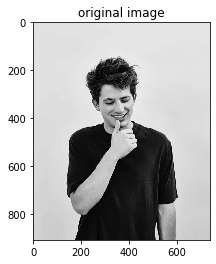

In [0]:
# read in data
im = Image.open("c.jpg").convert('L')
X = np.array(im) / 255
print(f"The size of original image is {X.shape}.")
plt.imshow(X, cmap='gray')
plt.title("original image")
plt.show()

Let's try this!

(It may take a while depending on your computer.)

Using LASSO to perform sparse coding.
The sparsity of R is 91.38%.


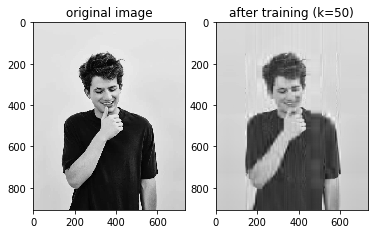

In [0]:
k = 50
D,R = dictionary_learning(X, k=k)
# You can change the parameter if you want
# iteration = 20
# D,R = dictionary_learning(X, k=k, iteration=iteration)
print(f'The sparsity of R is {(np.size(R) - np.count_nonzero(R))/np.size(R)*100:.2f}%.')

plt.subplot(121)
plt.imshow(X, cmap='gray')
plt.title('original image')
plt.subplot(122)
plt.imshow(np.dot(D,R), cmap='gray')
plt.title(f'after training (k={k})')
plt.show()

### Problem 2 b)
Now let's see why we want sparse coding by comparing the bytes needed to store the original image X as well as  dictionary D and representation R.

In [0]:
print(f'Bytes of X is {sys.getsizeof(X)}')
print(f'Bytes of D is {sys.getsizeof(D)}')
print(f'Bytes of R is {sys.getsizeof(sparse.csc_matrix(R))}')

Bytes of X is 5340528
Bytes of D is 112
Bytes of R is 56


### (Optional) Try dictionary learning using OMP instead of LASSO.

Using OMP to perform sparse coding.
The sparsity of R is 90.00%.


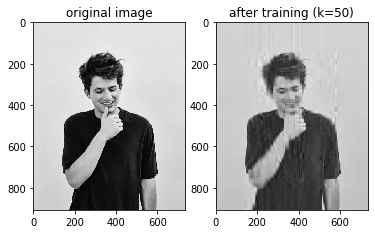

In [0]:
D_omp,R_omp = dictionary_learning(X, k=k, sparse_method="OMP")
print(f'The sparsity of R is {(np.size(R_omp) - np.count_nonzero(R_omp))/np.size(R_omp)*100:.2f}%.')

plt.subplot(121)
plt.imshow(X, cmap='gray')
plt.title('original image')
plt.subplot(122)
plt.imshow(np.dot(D_omp, R_omp), cmap='gray')
plt.title(f'after training (k={k})')
plt.show()